#Data Loading

In [13]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
from torch.optim import AdamW
import torch.nn.functional as F
import os
import pandas as pd
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
import seaborn as sns
import transformers
from sklearn.model_selection import train_test_split
import torch
from transformers import BertTokenizer, BertModel, TFBertModel
from tqdm import tqdm
from transformers import CLIPProcessor, CLIPModel
from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn
import torch.optim as optim
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate, LSTM, Layer, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image as keras_image
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

In [14]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]

dataset_path = kagglehub.dataset_download('williamscott701/memotion-dataset-7k')

In [ ]:
base_dir = '/kaggle/input/memotion-dataset-7k/memotion_dataset_7k'
csv_path = os.path.join(base_dir, 'labels.csv')
image_dir = os.path.join(base_dir, 'images')


df = pd.read_csv(csv_path)

df = df[['image_name', 'text_corrected', 'offensive']]

offensive_labels = ['offensive', 'very_offensive', 'hateful_offensive', 'slight']
df['label'] = df['offensive'].apply(lambda x: 1 if str(x).lower().strip() in offensive_labels else 0)


df['image_path'] = df['image_name'].apply(lambda x: os.path.join(image_dir, x))
df = df.dropna(subset=['text_corrected'])
# Preview
df.head()


,image_name,text_corrected,offensive,label,image_path
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,not_offensive,0,/kaggle/input/memotion-dataset-7k/memotion_dat...
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,not_offensive,0,/kaggle/input/memotion-dataset-7k/memotion_dat...
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,not_offensive,0,/kaggle/input/memotion-dataset-7k/memotion_dat...
3,image_4.png,10 Year Challenge - Sweet Dee Edition,very_offensive,1,/kaggle/input/memotion-dataset-7k/memotion_dat...
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,very_offensive,1,/kaggle/input/memotion-dataset-7k/memotion_dat...


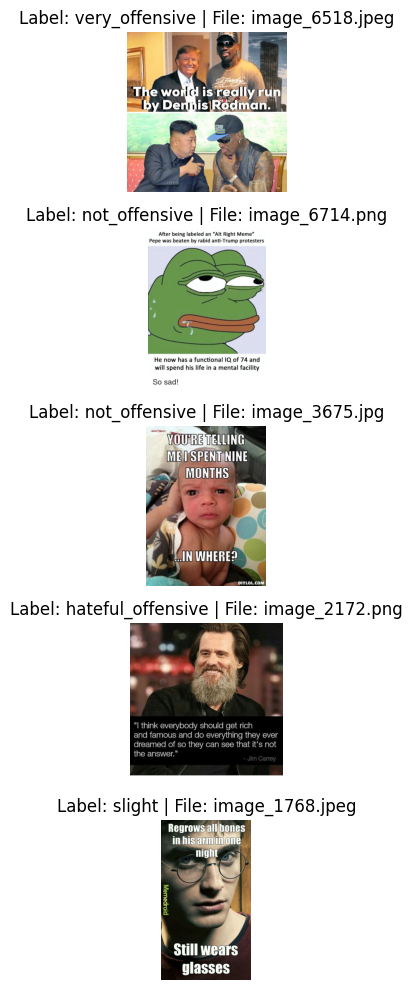

In [ ]:
sample_df = df.sample(5)
plt.figure(figsize=(12, 10))
for idx, row in enumerate(sample_df.itertuples(), 1):
    try:
        image = Image.open(row.image_path)
        if image.mode == 'P':
            image = image.convert('RGBA')
        image = image.convert('RGB')
        plt.subplot(5, 1, idx)
        plt.imshow(image)
        plt.title(f"Label: {row.offensive if 'offensive' in df.columns else 'N/A'} | File: {row.image_name}")
        plt.axis('off')
    except FileNotFoundError:
        print(f"⚠️ Missing image: {row.image_path}")
plt.tight_layout()
plt.show()

Binary Sentiment Distribution:
Not Offensive (0): 2710
Offensive (1): 4277


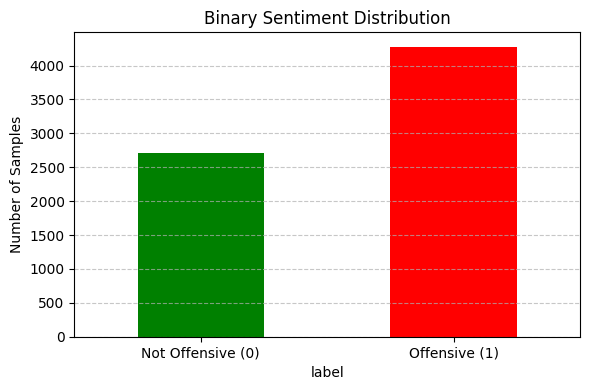

In [ ]:
label_counts = df['label'].value_counts().sort_index()

# Print distribution
print("Binary Sentiment Distribution:")
print(f"Not Offensive (0): {label_counts.get(0, 0)}")
print(f"Offensive (1): {label_counts.get(1, 0)}")

# Plotting
plt.figure(figsize=(6, 4))
label_counts.plot(kind='bar', color=['green', 'red'])
plt.xticks(ticks=[0, 1], labels=['Not Offensive (0)', 'Offensive (1)'], rotation=0)
plt.title('Binary Sentiment Distribution')
plt.ylabel('Number of Samples')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
train_df, temp_df = train_test_split(
    df,
    test_size=0.4,
    stratify=df['label'],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=42
)

In [ ]:
def clean_text_df(df):
    df = df.dropna(subset=['text_corrected'])
    df = df[df['text_corrected'].apply(lambda x: isinstance(x, str))]
    return df

train_df = clean_text_df(train_df)
val_df = clean_text_df(val_df)
test_df = clean_text_df(test_df)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 4192
Validation size: 1397
Test size: 1398


## Baseline Model

In [ ]:
majority_class = 1

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

val_preds = [majority_class]*len(val_df)
test_preds = [majority_class]*len(test_df)

val_labels = val_df['label'].tolist()
test_labels = test_df['label'].tolist()

# Evaluation
val_acc = accuracy_score(val_labels, val_preds)
val_f1 = f1_score(val_labels, val_preds)

test_acc = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds)

print(f"Validation Baseline Metrics:\n\tAccuracy: {val_acc:.4f}, F1 Score: {val_f1:.4f}")
print(f"Test Baseline Metrics:\n\tAccuracy: {test_acc:.4f}, F1 Score: {test_f1:.4f}")

Validation Baseline Metrics:
	Accuracy: 0.6120, F1 Score: 0.7593
Test Baseline Metrics:
	Accuracy: 0.6123, F1 Score: 0.7595


#Binary Classifier For a Multi-Modal BERT + CLIP System

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
def get_bert_embeddings(text_list, tokenizer, model, batch_size=32):
    all_embeddings = []

    for i in tqdm(range(0, len(text_list), batch_size)):
        batch_texts = text_list[i:i+batch_size]
        encodings = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=128)

        input_ids = encodings['input_ids'].to(device)
        attention_mask = encodings['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] token

        all_embeddings.append(cls_embeddings.cpu())

    return torch.cat(all_embeddings, dim=0)

In [ ]:
bert_train_embeddings = get_bert_embeddings(train_df['text_corrected'].tolist(), tokenizer, bert_model)
bert_val_embeddings = get_bert_embeddings(val_df['text_corrected'].tolist(), tokenizer, bert_model)
bert_test_embeddings = get_bert_embeddings(test_df['text_corrected'].tolist(), tokenizer, bert_model)


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 44/44 [00:04<00:00, 10.13it/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
def get_clip_embeddings(image_paths, processor, model, batch_size=32):
    all_embeddings = []

    for i in tqdm(range(0, len(image_paths), batch_size)):
        batch_paths = image_paths[i:i+batch_size]
        images = []

        for path in batch_paths:
          try:
              image = Image.open(path)
              if image.mode == 'P':
                  image = image.convert("RGBA").convert("RGB")
              else:
                  image = image.convert("RGB")
              images.append(image)
          except Exception as e:
              print(f"Error loading {path}: {e}")
              images.append(Image.new("RGB", (224, 224)))  # blank fallback

        inputs = processor(images=images, return_tensors="pt", padding=True).to(device)

        with torch.no_grad():
            outputs = model.get_image_features(**inputs)
            all_embeddings.append(outputs.cpu())

    return torch.cat(all_embeddings, dim=0)

In [ ]:
clip_train_embeddings = get_clip_embeddings(train_df['image_path'].tolist(), clip_processor, clip_model)
clip_val_embeddings = get_clip_embeddings(val_df['image_path'].tolist(), clip_processor, clip_model)
clip_test_embeddings = get_clip_embeddings(test_df['image_path'].tolist(), clip_processor, clip_model)

100%|██████████| 44/44 [00:29<00:00,  1.50it/s]


In [ ]:
X_train = torch.cat([bert_train_embeddings, clip_train_embeddings], dim=1)
X_val = torch.cat([bert_val_embeddings, clip_val_embeddings], dim=1)
X_test = torch.cat([bert_test_embeddings, clip_test_embeddings], dim=1)

y_train = torch.tensor(train_df['label'].values).long()
y_val = torch.tensor(val_df['label'].values).long()
y_test = torch.tensor(test_df['label'].values).long()

In [ ]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
class MultimodalClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(768 + 512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)  # Binary classification (logits)
        )

    def forward(self, x):
        return self.fc(x)

model = MultimodalClassifier().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)
def train(model, loader):
    model.train()
    total_loss, correct = 0, 0

    for x_batch, y_batch in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == y_batch).sum().item()

    accuracy = correct / len(loader.dataset)
    return total_loss / len(loader), accuracy

In [ ]:
def evaluate(model, loader):
    model.eval()
    total_loss, correct = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)

            correct += (preds == y_batch).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = correct / len(loader.dataset)
    f1 = f1_score(all_labels, all_preds, average='binary')
    return avg_loss, accuracy, f1

In [ ]:
for epoch in range(5):
    train_loss, train_acc = train(model, train_loader)
    val_loss, val_acc, val_f1 = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Val F1={val_f1:.4f}")

Epoch 1: Train Acc=0.6119, Val Acc=0.6120, Val F1=0.7593
Epoch 2: Train Acc=0.6124, Val Acc=0.6120, Val F1=0.7593
Epoch 3: Train Acc=0.6112, Val Acc=0.6120, Val F1=0.7593
Epoch 4: Train Acc=0.6119, Val Acc=0.6120, Val F1=0.7593
Epoch 5: Train Acc=0.6116, Val Acc=0.6120, Val F1=0.7593


In [ ]:
test_loss, test_acc, test_f1 = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}, Test F1-score: {test_f1:.4f}")

Test Accuracy: 0.6137, Test F1-score: 0.7602


#Multi Class BERT and CLIP Model

  0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 43/43 [00:19<00:00,  2.18it/s]


Epoch 1: Train Acc=0.3895, Val Acc=0.4035, Val F1=0.2963
Epoch 2: Train Acc=0.3902, Val Acc=0.3747, Val F1=0.3417
Epoch 3: Train Acc=0.3902, Val Acc=0.3732, Val F1=0.3576
Epoch 4: Train Acc=0.4038, Val Acc=0.3755, Val F1=0.3623
Epoch 5: Train Acc=0.4134, Val Acc=0.3525, Val F1=0.3524
Test Accuracy: 0.3759, Test F1-score: 0.3751


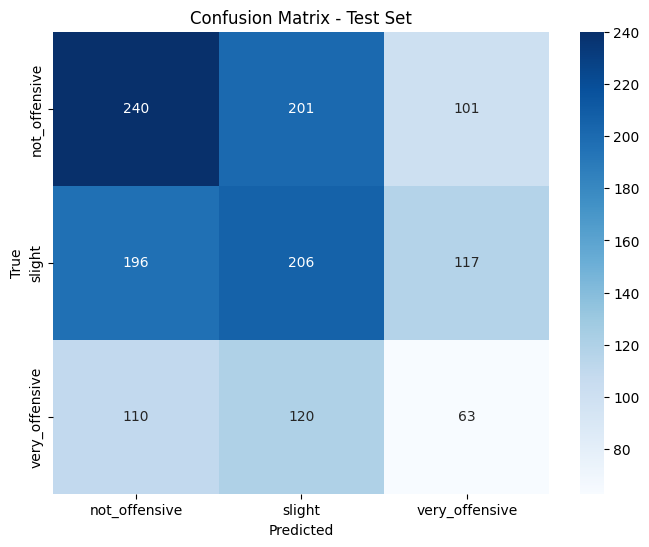

In [17]:
base_dir = '/kaggle/input/memotion-dataset-7k/memotion_dataset_7k'
csv_path = os.path.join(base_dir, 'labels.csv')
image_dir = os.path.join(base_dir, 'images')

df = pd.read_csv(csv_path)
df = df[['image_name', 'text_corrected', 'offensive']]
label_map = {
    'not_offensive': 0,
    'slight': 1,
    'very_offensive': 2
}
df['label'] = df['offensive'].str.lower().str.strip().map(label_map)
df = df[df['label'].notnull()]
df['label'] = df['label'].astype(int)
df['image_path'] = df['image_name'].apply(lambda x: os.path.join(image_dir, x))
df = df.dropna(subset=['text_corrected'])
train_df, temp_df = train_test_split(df, test_size=0.4, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

def clean_text_df(df):
    df = df.dropna(subset=['text_corrected'])
    df = df[df['text_corrected'].apply(lambda x: isinstance(x, str))]
    return df

train_df = clean_text_df(train_df)
val_df = clean_text_df(val_df)
test_df = clean_text_df(test_df)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)

def get_bert_embeddings(text_list, tokenizer, model, batch_size=32):
    all_embeddings = []
    for i in tqdm(range(0, len(text_list), batch_size)):
        batch_texts = text_list[i:i+batch_size]
        encodings = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=128)
        input_ids = encodings['input_ids'].to(device)
        attention_mask = encodings['attention_mask'].to(device)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]
        all_embeddings.append(cls_embeddings.cpu())
    return torch.cat(all_embeddings, dim=0)

bert_train_embeddings = get_bert_embeddings(train_df['text_corrected'].tolist(), tokenizer, bert_model)
bert_val_embeddings = get_bert_embeddings(val_df['text_corrected'].tolist(), tokenizer, bert_model)
bert_test_embeddings = get_bert_embeddings(test_df['text_corrected'].tolist(), tokenizer, bert_model)

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
ImageFile.LOAD_TRUNCATED_IMAGES = True

def get_clip_embeddings(image_paths, processor, model, batch_size=32):
    all_embeddings = []
    for i in tqdm(range(0, len(image_paths), batch_size)):
        batch_paths = image_paths[i:i+batch_size]
        images = []
        for path in batch_paths:
            try:
                image = Image.open(path)
                if image.mode == 'P':
                    image = image.convert("RGBA").convert("RGB")
                else:
                    image = image.convert("RGB")
                images.append(image)
            except Exception as e:
                print(f"Error loading {path}: {e}")
                images.append(Image.new("RGB", (224, 224)))
        inputs = processor(images=images, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            outputs = model.get_image_features(**inputs)
            all_embeddings.append(outputs.cpu())
    return torch.cat(all_embeddings, dim=0)

clip_train_embeddings = get_clip_embeddings(train_df['image_path'].tolist(), clip_processor, clip_model)
clip_val_embeddings = get_clip_embeddings(val_df['image_path'].tolist(), clip_processor, clip_model)
clip_test_embeddings = get_clip_embeddings(test_df['image_path'].tolist(), clip_processor, clip_model)

X_train = torch.cat([bert_train_embeddings, clip_train_embeddings], dim=1)
X_val = torch.cat([bert_val_embeddings, clip_val_embeddings], dim=1)
X_test = torch.cat([bert_test_embeddings, clip_test_embeddings], dim=1)

y_train = torch.tensor(train_df['label'].values).long()
y_val = torch.tensor(val_df['label'].values).long()
y_test = torch.tensor(test_df['label'].values).long()

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(df['label']), y=df['label'])
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

class MultimodalClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
          nn.Linear(768 + 512, 512),
          nn.ReLU(),
          nn.Dropout(0.3),
          nn.Linear(512, 128),
          nn.ReLU(),
          nn.Dropout(0.3),
          nn.Linear(128, 3)
        )
    def forward(self, x):
        return self.fc(x)

model = MultimodalClassifier().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

def train(model, loader):
    model.train()
    total_loss, correct = 0, 0
    for x_batch, y_batch in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
    accuracy = correct / len(loader.dataset)
    return total_loss / len(loader), accuracy

def evaluate(model, loader, return_preds=False):
    model.eval()
    total_loss, correct = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    avg_loss = total_loss / len(loader)
    accuracy = correct / len(loader.dataset)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    if return_preds:
        return avg_loss, accuracy, f1, all_preds, all_labels
    else:
        return avg_loss, accuracy, f1

for epoch in range(5):
    train_loss, train_acc = train(model, train_loader)
    val_loss, val_acc, val_f1 = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Val F1={val_f1:.4f}")

test_loss, test_acc, test_f1, test_preds, test_labels = evaluate(model, test_loader, return_preds=True)
print(f"Test Accuracy: {test_acc:.4f}, Test F1-score: {test_f1:.4f}")

labels = ['not_offensive', 'slight', 'very_offensive']
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()

# Binary Classifier For a Multi-Modal BiTransformer (MMBT) System

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertModel, BertTokenizer, CLIPModel, CLIPProcessor
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageFile
from torchvision import models, transforms
from tqdm import tqdm
from sklearn.utils import class_weight
from sklearn.metrics import f1_score
from torch.nn import LayerNorm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ImageFile.LOAD_TRUNCATED_IMAGES = True

class MemeDataset(Dataset):
    def __init__(self, df, bert_tokenizer, image_transform):
        self.df = df.reset_index(drop=True)
        self.bert_tokenizer = bert_tokenizer
        self.image_transform = image_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.loc[idx, 'text_corrected']
        image_path = self.df.loc[idx, 'image_path']
        label = self.df.loc[idx, 'label']

        #Tokenize text (via BERT)
        text_tokens = self.bert_tokenizer(text, padding='max_length', truncation=True,
                                      max_length=128, return_tensors="pt")

        #Load image + apply image preprocessing
        image = Image.open(image_path).convert('RGB')
        image = self.image_transform(image)

        return {
            'input_ids': text_tokens['input_ids'].squeeze(0),
            'attention_mask': text_tokens['attention_mask'].squeeze(0),
            'image': image,
            'label': torch.tensor(label, dtype=torch.long)
        }

#Configure image preprocessing/augmentation for training
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



In [ ]:
class MMBTModelResNet(nn.Module):
    """Configuration of MMBT Model:
        Basic architecture:
          Text Input --> Text Embeddings via BERT
          Image Input --> Image Vector via ResNet
          Concatenate Text and Image
          --> Multimodal Transformer Encoder Layer
          --> Classification --> Output Logits
    """
    def __init__(self, hidden_dim=256,
                 num_classes=2, n_transformer_layers=2, n_heads=4, dropout=0.4):
        super().__init__()

        #Encode text input (BERT)
        self.text_encoder = BertModel.from_pretrained('bert-base-uncased')
        self.text_hidden_size = self.text_encoder.config.hidden_size #default=768

        #Encode image input (ResNet50)
        resnet_model = models.resnet50(pretrained=True)
        self.image_encoder = nn.Sequential(*list(resnet_model.children())[:-1])
        self.image_hidden_size = 2048

        #Project text and image features for shared embedding space
        self.text_proj = nn.Linear(self.text_hidden_size, hidden_dim)
        self.image_proj = nn.Linear(self.image_hidden_size, hidden_dim)

        #Fusion transformer layer (Text+Input) with 4 attention heads to cross inform
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=n_heads, dropout=dropout, dim_feedforward = 1024)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_transformer_layers)

        #Classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, input_ids, attention_mask, images):
        #BERT text processing
        text_outputs = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_embeds = text_outputs.last_hidden_state
        text_embeds = self.text_proj(text_embeds)

        #ResNet image processing
        img_features = self.image_encoder(images)
        img_features = img_features.squeeze(-1).squeeze(-1)
        img_embeds = self.image_proj(img_features)
        img_embeds = img_embeds.unsqueeze(1)

        #Concatenate embeddings to combine sequences
        combined = torch.cat([text_embeds, img_embeds], dim=1)
        combined = combined.permute(1, 0, 2) #reorder format for transformer input

        #Apply transformation
        fusion_output = self.transformer_encoder(combined)
        pooled = fusion_output[0]

        #Classify
        logits = self.classifier(pooled)
        return logits



In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') #Initialize Bert Tokenizer

train_dataset = MemeDataset(train_df, bert_tokenizer, image_transform) #Format training dataset for model
val_dataset = MemeDataset(val_df, bert_tokenizer, image_transform) #Format validation dataset for model
test_dataset = MemeDataset(test_df, bert_tokenizer, image_transform) #Format test dataset for model

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #Initialize training loader with batch size 32, and shuffling
val_loader = DataLoader(val_dataset, batch_size=16) #Initialize validation loader with batch size 16, no shuffling
test_loader = DataLoader(test_dataset, batch_size=16) #Initialize testing load with batch size 16, no shuffling


In [ ]:
model = MMBTModelResNet().to(device) #Initialize MMBT model
not_offensive_data, offensive_data = train_df['label'].value_counts()[0], train_df['label'].value_counts()[1]
offensive_weight = torch.tensor([not_offensive_data / offensive_data], dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=offensive_weight) #Initialize Loss | Notes: switched to BCE weighted loss over cross entropy to deal with imbalanced training data distribution
optimizer = optim.Adam(model.parameters(), lr=2e-5, weight_decay=5e-4) #Initialize Optimizer | Notes: learning rate and weight decay modified to mitigate overfitting

def train_epoch(model, loader):
    """Training Function"""
    model.train()
    total_loss, correct = 0, 0
    for batch in tqdm(loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        labels = batch['label'].float().unsqueeze(1).to(device)


        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).long()
        correct += (preds == labels.long()).sum().item()

    return total_loss / len(loader), correct / len(loader.dataset)

def eval_epoch(model, loader):
    """Evaluation Function"""
    model.eval()
    total_loss, correct = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].float().unsqueeze(1).to(device)  # shape: (B, 1)


            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).long()
            correct += (preds == labels.long()).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds)

    return total_loss / len(loader), correct / len(loader.dataset), f1


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 110MB/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batc

In [ ]:
#TRAIN/EVAL - batch 32
best_f1 = 0
epochs_without_improvement = 0
patience = 3

for epoch in range(10):
    train_loss, train_acc = train_epoch(model, train_loader)
    val_loss, val_acc, f1 = eval_epoch(model, val_loader)
    print(f"Epoch {epoch+1} | Train acc: {train_acc:.4f} | Val acc: {val_acc:.4f} | f1 score: {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), 'best_model.pt')
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print("Early stopping triggered.")
        break

    torch.cuda.empty_cache()

#TEST
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc, f1 = eval_epoch(model, test_loader)
print(f"Test accuracy: {test_acc:.4f}, F1: {f1:.4f}")


  5%|▌         | 7/131 [00:08<02:32,  1.23s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 131/131 [02:44<00:00,  1.26s/it]


Epoch 1 | Train acc: 0.4933 | Val acc: 0.6120 | f1 score: 0.7593


 15%|█▍        | 19/131 [00:23<02:29,  1.33s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 131/131 [02:50<00:00,  1.30s/it]


Epoch 2 | Train acc: 0.5088 | Val acc: 0.4724 | f1 score: 0.4717


 38%|███▊      | 50/131 [01:04<01:43,  1.28s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 131/131 [02:51<00:00,  1.31s/it]


Epoch 3 | Train acc: 0.5491 | Val acc: 0.5197 | f1 score: 0.5729


 58%|█████▊    | 76/131 [01:41<01:12,  1.32s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 131/131 [02:54<00:00,  1.33s/it]


Epoch 4 | Train acc: 0.5720 | Val acc: 0.5297 | f1 score: 0.5962
Early stopping triggered.
Test accuracy: 0.6123, F1: 0.7595


In [ ]:
#TRAIN/EVAL - batch 32
best_f1 = 0
epochs_without_improvement = 0
patience = 4

for epoch in range(10):
    train_loss, train_acc = train_epoch(model, train_loader)
    val_loss, val_acc, f1 = eval_epoch(model, val_loader)
    print(f"Epoch {epoch+1} | Train acc: {train_acc:.4f} | Val acc: {val_acc:.4f} | f1 score: {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), 'best_model.pt')
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print("Early stopping triggered.")
        break

    torch.cuda.empty_cache()

#TEST
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc, f1 = eval_epoch(model, test_loader)
print(f"Test accuracy: {test_acc:.4f}, F1: {f1:.4f}")


 31%|███       | 40/131 [00:52<02:01,  1.34s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 131/131 [02:48<00:00,  1.29s/it]


Epoch 1 | Train acc: 0.4969 | Val acc: 0.6034 | f1 score: 0.7452


 27%|██▋       | 36/131 [00:48<02:10,  1.37s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 131/131 [02:56<00:00,  1.35s/it]


Epoch 2 | Train acc: 0.5391 | Val acc: 0.5812 | f1 score: 0.7014


 12%|█▏        | 16/131 [00:20<02:29,  1.30s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 131/131 [02:55<00:00,  1.34s/it]


Epoch 3 | Train acc: 0.5880 | Val acc: 0.5297 | f1 score: 0.5907


  8%|▊         | 11/131 [00:14<02:43,  1.36s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 131/131 [02:53<00:00,  1.32s/it]


Epoch 4 | Train acc: 0.6815 | Val acc: 0.4710 | f1 score: 0.4538


 89%|████████▉ | 117/131 [02:34<00:17,  1.26s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 131/131 [02:53<00:00,  1.32s/it]


Epoch 5 | Train acc: 0.8001 | Val acc: 0.5089 | f1 score: 0.5457
Early stopping triggered.
Test accuracy: 0.6023, F1: 0.7447
